# Predicting the Past, United States Extension (Decay on) 

## Introduction
This is an add on of Predicting the Past, United States Extension where decay is now turned on. 
This add on includes comparisons between _CYCLUS_ output and CURIE data for the United States from 1968 to 2013 where decay is turned on for: 
 - Total spent fuel mass 
 - Mass of major isotopes in spent fuel 

The CURIE data is taken from UNF_ST&DARDS Unified Database and the Automatic Document Generator. 

The _CYCLUS_ data was generated by using published data of the commericial reactors that have operated in the United States. The _CYCLUS_ input file and simulation were generated in the original Predicting the Past, United States notebook. This notebook uses the SQL data file produced from the _CYCLUS_ simulation to do further analysis. 

Decay was turned on by adding 10 storage facilities to the input xml file that each take in consecutive ~ 5 years of spent fuel (with exception to 1st storage facility that takes ~ 10 years and 10th that takes everything after 2014) and outputs the spent fuel at year 2020. 

Most of the subsequent code is copied from united_states_extention.ipynb

** Import necessary libraries ** 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import csv
import collections
import dateutil.parser as date
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image, HTML, display
import seaborn as sns 

sys.path.append('../../../scripts/')
import analysis as an

** Run Cyclus simulation **

In [20]:
!rm cyclus/united_states_decayon_underestm_33.sqlite
!cyclus -i ./cyclus/input/united_states_underestm_33.xml -o ./cyclus/united_states_decayon_underestm_33.sqlite --warn-limit 0

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

** Setting up to analyze sqlite file ** 

In [21]:
# Before this step, must download the output sqlite files from the fuel-cycles box. 
# fuel-cycle/cyclus_output/predicting_the_past_validation 
# and put into a directory named cyclus 

def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()


cursor = get_cursor('cyclus/united_states_decayon_underestm.sqlite')
cursor_33 = get_cursor('cyclus/united_states_decayon_underestm_33.sqlite')

In [6]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep

** Get total spent fuel produced after cooling in spent fuel pool until 2020** 

In [22]:
def total_spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """

    init_yr, init_month, duration, timestep = get_timesteps(cursor)
    spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                             'INNER JOIN resources '
                             'ON transactions.resourceid = resources.resourceid '
                             'WHERE Commodity = "cool_spent_uox1" ' # must be changed to get each subsequent pool
                             'GROUP BY time ').fetchall()
    spent_fuel_list = an.get_timeseries(spent_fuel,duration,True)
    spent_fuel_total = np.sum(spent_fuel_list)
    return spent_fuel_total 

total_spentfuel = total_spent_fuel_produced(cursor_33)
total_spentfuel

1459.8340248962554

In [6]:
# underestm results (recorded from running above function for each pool)
total_spentfuel_1 = 1459.834024896255
total_spentfuel_2 = 6059.922964424133
total_spentfuel_3 = 7679.995986667509
total_spentfuel_4 = 10206.246547853802
total_spentfuel_5 = 7099.9127270253275
total_spentfuel_6 = 7499.889293245296
total_spentfuel_7 = 7199.918610978797
total_spentfuel_8 = 6899.824909870031
total_spentfuel_9 = 5999.907217196068

total_spentfuel_array = [total_spentfuel_1,total_spentfuel_2,total_spentfuel_3,total_spentfuel_4,total_spentfuel_5,total_spentfuel_6,total_spentfuel_7,total_spentfuel_8,total_spentfuel_9]
total_spentfuel_array_cum = np.cumsum(total_spentfuel_array)
print(total_spentfuel_array_cum)

[ 1459.8340249   7519.75698932 15199.75297599 25405.99952384
 32505.91225087 40005.80154411 47205.72015509 54105.54506496
 60105.45228216]


** Get specific isotope composition from total spent fuel produced after cooling in spent fuel pool until 2020** 

In [40]:
def isotope_total(cur):
    """ Find list of isotopes present in spent fuel output by reactor 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors
    """    
    
    init_yr, init_month, duration, timestep = get_timesteps(cursor)
    isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                           'INNER JOIN resources '
                           'ON transactions.resourceid = resources.resourceid '
                           'LEFT OUTER JOIN compositions '
                           'ON resources.qualid = compositions.qualid '
                           'WHERE Commodity = "cool_spent_uox9" AND nucid =  952410000 ' # must specify isotope and pool
                           ' GROUP BY time ').fetchall()
    isotope_list = an.get_timeseries(isotopes,duration,True)
    isotope_total = np.sum(isotope_list)
    return isotope_total

#total_U238 = isotope_total(cursor) # in MTHM 
total_Am241_9= isotope_total(cursor_33)

In [41]:
total_Am241_9

2.0849610101933935

In [43]:
# BU 33 underestm results Am 241 (recorded from running above function isotope_total for each pool and isotope)
underestm33_total_Am241_1 = 1.6222975257439214
underestm33_total_Am241_2 = 6.48879433432306
underestm33_total_Am241_3 = 7.970356933129654
underestm33_total_Am241_4 = 9.966770666682207
underestm33_total_Am241_5 = 6.346417944878742
underestm33_total_Am241_6 = 5.848086988477862
underestm33_total_Am241_7 = 4.91184024159984
underestm33_total_Am241_8 = 3.5705435935923364
underestm33_total_Am241_9 = 2.0849610101933935

underestm33_Am241_array = [underestm33_total_Am241_1,underestm33_total_Am241_2,underestm33_total_Am241_3,underestm33_total_Am241_4,underestm33_total_Am241_5,underestm33_total_Am241_6,underestm33_total_Am241_7,underestm33_total_Am241_8,underestm33_total_Am241_9]
underestm33_Am241_array_cum = np.cumsum(underestm33_Am241_array)
print(underestm33_Am241_array_cum)

[ 1.62229753  8.11109186 16.08144879 26.04821946 32.3946374  38.24272439
 43.15456463 46.72510823 48.81006924]


In [11]:
# underestm results Am 241 (recorded from running above function isotope_total for each pool and isotope)
underestm_total_Am241_1 = 2.406506954975244
underestm_total_Am241_2 = 9.630117240987541
underestm_total_Am241_3 = 11.836714872090765
underestm_total_Am241_4 = 14.815337470964097
underestm_total_Am241_5 = 9.446660273219482
underestm_total_Am241_6 = 8.72337686078903
underestm_total_Am241_7 = 7.353315169827008
underestm_total_Am241_8 = 5.384005292245291
underestm_total_Am241_9 = 3.186294208976122

underestm_Am241_array = [underestm_total_Am241_1,underestm_total_Am241_2,underestm_total_Am241_3,underestm_total_Am241_4,underestm_total_Am241_5,underestm_total_Am241_6,underestm_total_Am241_7,underestm_total_Am241_8,underestm_total_Am241_9]
underestm_Am241_array_cum = np.cumsum(underestm_Am241_array)
print(underestm_Am241_array_cum)

[ 2.40650695 12.0366242  23.87333907 38.68867654 48.13533681 56.85871367
 64.21202884 69.59603414 72.78232834]


In [8]:
# underestm results Cs 137 (recorded from running above function isotope_total for each pool and isotope)
underestm_total_Cs137_1 = 0.5683681234792628
underestm_total_Cs137_2 = 2.630113778023083
underestm_total_Cs137_3 = 3.7722413797332344
underestm_total_Cs137_4 = 5.597003780641794
underestm_total_Cs137_5 = 4.327620057269529
underestm_total_Cs137_6 = 5.014614744627627
underestm_total_Cs137_7 = 5.606881611617997
underestm_total_Cs137_8 = 6.029354298185069
underestm_total_Cs137_9 = 5.6073869196633455
underestm_Cs137_array = [underestm_total_Cs137_1,underestm_total_Cs137_2,underestm_total_Cs137_3,underestm_total_Cs137_4,underestm_total_Cs137_5,underestm_total_Cs137_6,underestm_total_Cs137_7,underestm_total_Cs137_8,underestm_total_Cs137_9]
underestm_Cs137_array_cum = np.cumsum(underestm_Cs137_array)
print(underestm_Cs137_array_cum)

[ 0.56836812  3.1984819   6.97072328 12.56772706 16.89534712 21.90996186
 27.51684348 33.54619777 39.15358469]


In [9]:
# overestm results Sr 90 (recorded from running above function isotope_total for each pool and isotope)
overestm_total_Sr90_1 = 0.12146430472814222
overestm_total_Sr90_2 = 0.6360373602009256
overestm_total_Sr90_3 = 0.9169586003608243
overestm_total_Sr90_4 = 1.3667016442617013
overestm_total_Sr90_5 = 1.0628784739861659
overestm_total_Sr90_6 = 1.237981566732399
overestm_total_Sr90_7 = 1.3913619002628377
overestm_total_Sr90_8 = 1.503943937316631
overestm_total_Sr90_9 = 1.441468792558859
overestm_Sr90_array = [overestm_total_Sr90_1,overestm_total_Sr90_2,overestm_total_Sr90_3,overestm_total_Sr90_4,overestm_total_Sr90_5,overestm_total_Sr90_6,overestm_total_Sr90_7,overestm_total_Sr90_8,overestm_total_Sr90_9]
overestm_Sr90_array_cum = np.cumsum(overestm_Sr90_array)
print(overestm_Sr90_array_cum)

[0.1214643  0.75750166 1.67446027 3.04116191 4.10404038 5.34202195
 6.73338385 8.23732779 9.67879658]


In [10]:
# underestm results Sr 90 (recorded from running above function isotope_total for each pool and isotope)
underestm_total_Sr90_1 = 0.15452925292925823
underestm_total_Sr90_2 = 0.7188445552717379
underestm_total_Sr90_3 = 1.0363395780738163
underestm_total_Sr90_4 = 1.5456114403611727
underestm_total_Sr90_5 = 1.201257070716301
underestm_total_Sr90_6 = 1.3991572210463534
underestm_total_Sr90_7 = 1.572506472219997
underestm_total_Sr90_8 = 1.6997458013276288
underestm_total_Sr90_9 = 1.5871940447451518
underestm_Sr90_array = [underestm_total_Sr90_1,underestm_total_Sr90_2,underestm_total_Sr90_3,underestm_total_Sr90_4,underestm_total_Sr90_5,underestm_total_Sr90_6,underestm_total_Sr90_7,underestm_total_Sr90_8,underestm_total_Sr90_9]
underestm_Sr90_array_cum = np.cumsum(underestm_Sr90_array)
print(underestm_Sr90_array_cum)

[ 0.15452925  0.87337381  1.90971339  3.45532483  4.6565819   6.05573912
  7.62824559  9.32799139 10.91518544]


In [12]:
# underestm results U 238 (recorded from running above function isotope_total for each pool and isotope)
underestm_total_U238_1 = 1415.5288655716008
underestm_total_U238_2 = 5875.281231084658
underestm_total_U238_3 = 7446.9049235073
underestm_total_U238_4 = 9895.754229627393
underestm_total_U238_5 = 6882.973474142602
underestm_total_U238_6 = 7268.386321917455
underestm_total_U238_7 = 6981.383306470415
underestm_total_U238_8 = 6690.394450056836
underestm_total_U238_9 = 5815.8605456477635

underestm_U238_array = [underestm_total_U238_1,underestm_total_U238_2,underestm_total_U238_3,underestm_total_U238_4,underestm_total_U238_5,underestm_total_U238_6,underestm_total_U238_7,underestm_total_U238_8,underestm_total_U238_9]
underestm_U238_array_cum = np.cumsum(underestm_U238_array)
print(underestm_U238_array_cum)

[ 1415.52886557  7290.81009666 14737.71502016 24633.46924979
 31516.44272393 38784.82904585 45766.21235232 52456.60680238
 58272.46734803]


In [13]:
# underestm results Pu 240 (recorded from running above function isotope_total for each pool and isotope)
underestm_total_Pu240_1 = 4.591810677980021
underestm_total_Pu240_2 = 18.889019615188168
underestm_total_Pu240_3 = 24.12406906900075
underestm_total_Pu240_4 = 31.864147194152135
underestm_total_Pu240_5 = 21.925217022798904
underestm_total_Pu240_6 = 22.599608166910226
underestm_total_Pu240_7 = 22.466484982057917
underestm_total_Pu240_8 = 21.466891890288522
underestm_total_Pu240_9 = 18.190262491268662

underestm_Pu240_array = [underestm_total_Pu240_1,underestm_total_Pu240_2,underestm_total_Pu240_3,underestm_total_Pu240_4,underestm_total_Pu240_5,underestm_total_Pu240_6,underestm_total_Pu240_7,underestm_total_Pu240_8,underestm_total_Pu240_9]
underestm_Pu240_array_cum = np.cumsum(underestm_Pu240_array)
print(underestm_Pu240_array_cum)

[  4.59181068  23.48083029  47.60489936  79.46904656 101.39426358
 123.99387175 146.46035673 167.92724862 186.11751111]


In [14]:
# overestm results Pu 239 (recorded from running above function isotope_total for each pool and isotope)
overestm_total_Pu239_1 = 9.351000018807493
overestm_total_Pu239_2 = 38.49795503271981
overestm_total_Pu239_3 = 49.21255202764081
overestm_total_Pu239_4 = 65.03868216089664
overestm_total_Pu239_5 = 44.84905167914863
overestm_total_Pu239_6 = 46.31855331768617
overestm_total_Pu239_7 = 46.15850053531664
overestm_total_Pu239_8 = 44.239822637165
overestm_total_Pu239_9 = 37.59728607440279

overestm_Pu239_array = [overestm_total_Pu239_1, overestm_total_Pu239_2, overestm_total_Pu239_3, overestm_total_Pu239_4, overestm_total_Pu239_5, overestm_total_Pu239_6, overestm_total_Pu239_7, overestm_total_Pu239_8, overestm_total_Pu239_9]
overestm_Pu239_array_cum = np.cumsum(overestm_Pu239_array)
print(overestm_Pu239_array_cum)

[  9.35100002  47.84895505  97.06150708 162.10018924 206.94924092
 253.26779424 299.42629477 343.66611741 381.26340348]


In [15]:
# underestm results Pu 239 (recorded from running above function isotope_total for each pool and isotope)
underestm_Pu239_array_cum = [  9.35330724,  47.85605458,  97.07469715, 162.16246537,
       207.01699025, 253.3411486 , 299.50518161, 343.75024945,
       381.35100507]
print(underestm_Pu239_array_cum)

[9.35330724, 47.85605458, 97.07469715, 162.16246537, 207.01699025, 253.3411486, 299.50518161, 343.75024945, 381.35100507]


## CURIE Data Analysis 

In [16]:
names = ['assembly_id','reactor_id', 'reactor_type', 'initial_uranium_kg','initial_enrichment','discharge_burnup','discharge_date','discharge_time','total_assembly_decay_heat_kw','name','evaluation_date','total_mass_g','total_radioactivity_curies']
df = pd.read_csv('SNF_nuclide_2020_07_01.dat',
                  sep='\s+',
                  index_col=False, 
                  names = names)

In [17]:
date_isotope_mass = df[['discharge_date','name','total_mass_g']]
date_mass = df[['discharge_date','total_mass_g']]

In [18]:
spent_fuel_mass = date_mass.groupby('discharge_date').sum()
spent_fuel_mass_cum = spent_fuel_mass.cumsum()
spent_fuel_mass_cum['total_mass_g'] = spent_fuel_mass_cum['total_mass_g'].apply(lambda x: x*0.000001)
spent_fuel_mass_cum = spent_fuel_mass_cum.rename(columns = {'total_mass_g':'total_mass_MTHM_CURIE'})
spent_fuel_mass_cum.index.names = ['discharge_date']

In [19]:
CURIE_isotope = date_isotope_mass.pivot_table(index='discharge_date',columns='name',aggfunc=sum)
CURIE_isotope_cum_all = CURIE_isotope.cumsum()

** CURIE and CYCLUS data on same plot for total spent fuel mass** 

In [1]:
index = spent_fuel_mass_cum.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2014-01-01']
data = spent_fuel_mass_cum.values
data2 = total_spentfuel_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/cumulative_mass_spent_fuel_decayon.png', dpi=300)

NameError: name 'spent_fuel_mass_cum' is not defined

** CURIE and CYCLUS data on same plot for total spent fuel mass for specific isotopes** 

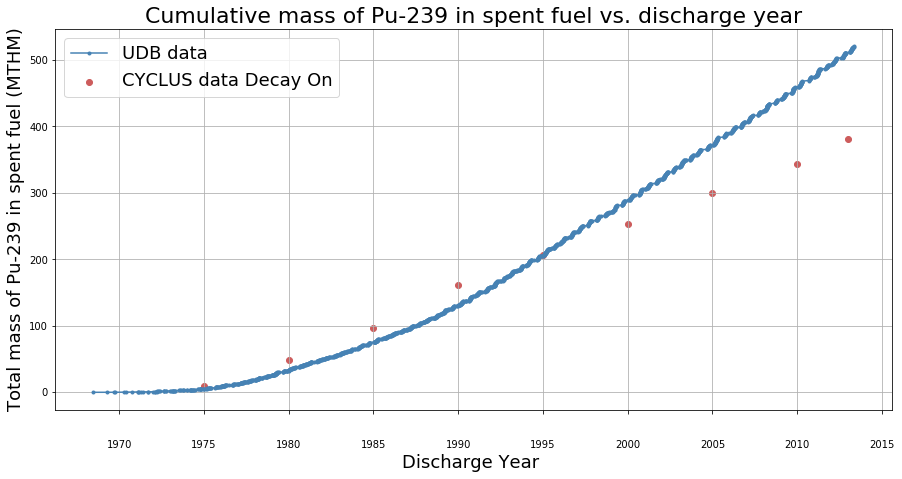

In [47]:
# Pu 239 
CURIE_isotope_single_pu239 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'pu-239')] # isotope name 
CURIE_isotope_single_pu239 = CURIE_isotope_single_pu239.to_frame()
CURIE_isotope_single_pu239 = CURIE_isotope_single_pu239.multiply(0.000001)
index = CURIE_isotope_single_pu239.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_pu239.columns.values)
data = CURIE_isotope_single_pu239.values
data2 = underestm_Pu239_array_cum
data3 = overestm_Pu239_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Pu-239 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Pu-239 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Pu-239_cumulative_mass_spent_fuel_decayon.png', dpi=300)

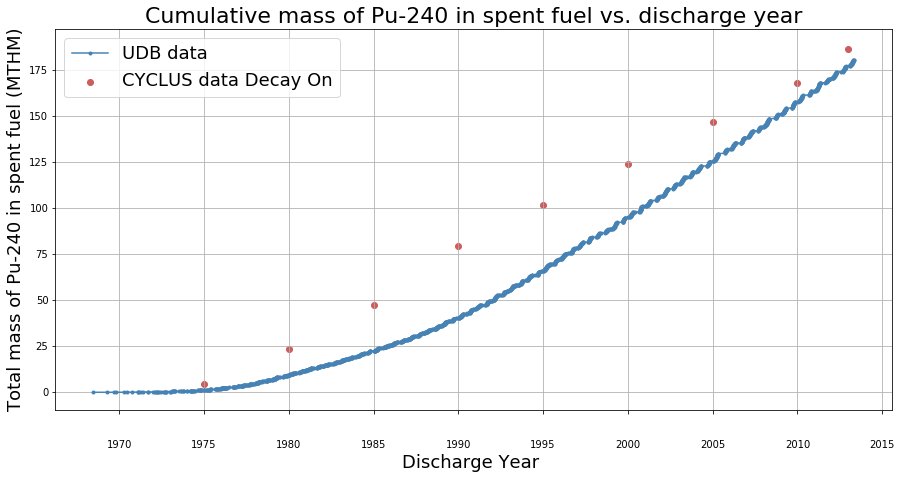

In [48]:
# Pu 240
CURIE_isotope_single_pu240 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'pu-240')] # isotope name 
CURIE_isotope_single_pu240 = CURIE_isotope_single_pu240.to_frame()
CURIE_isotope_single_pu240 = CURIE_isotope_single_pu240.multiply(0.000001)
index = CURIE_isotope_single_pu240.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_pu240.columns.values)
data = CURIE_isotope_single_pu240.values
data2 = underestm_Pu240_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Pu-240 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Pu-240 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Pu-240_cumulative_mass_spent_fuel_decayon.png', dpi=300)

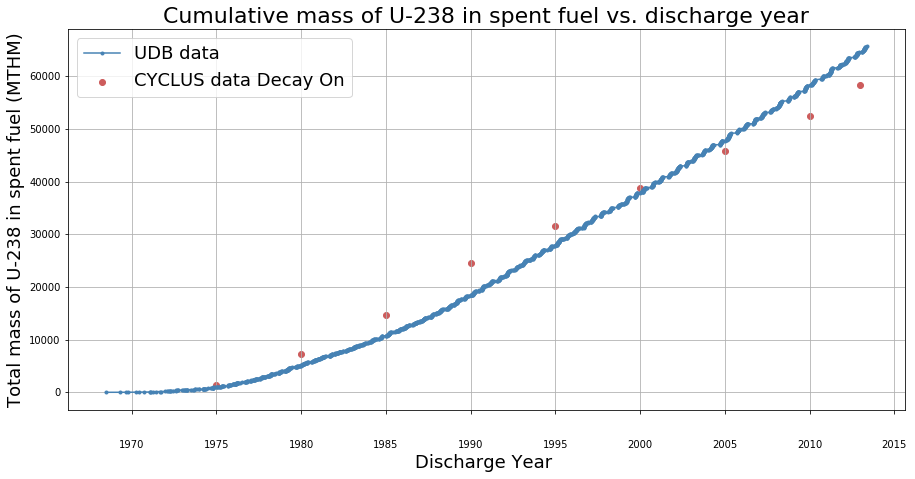

In [49]:
# U 238
CURIE_isotope_single_u238 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'u-238')] # isotope name 
CURIE_isotope_single_u238 = CURIE_isotope_single_u238.to_frame()
CURIE_isotope_single_u238 = CURIE_isotope_single_u238.multiply(0.000001)
index = CURIE_isotope_single_u238.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_u238.columns.values)
data = CURIE_isotope_single_u238.values
data2 = underestm_U238_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of U-238 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of U-238 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/U-238_cumulative_mass_spent_fuel_decayon.png', dpi=300)

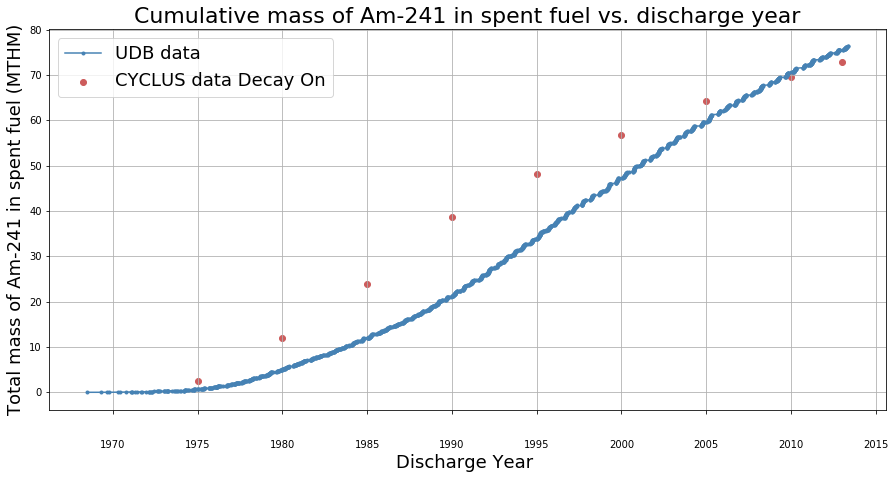

In [50]:
# Am-241
CURIE_isotope_single_am241 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'am-241')] # isotope name 
CURIE_isotope_single_am241 = CURIE_isotope_single_am241.to_frame()
CURIE_isotope_single_am241 = CURIE_isotope_single_am241.multiply(0.000001)
index = CURIE_isotope_single_am241.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_am241.columns.values)
data = CURIE_isotope_single_am241.values
data2 = underestm_Am241_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)
col_no = -1

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Am-241 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Am-241 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Am-241_cumulative_mass_spent_fuel_decayon.png', dpi=300)

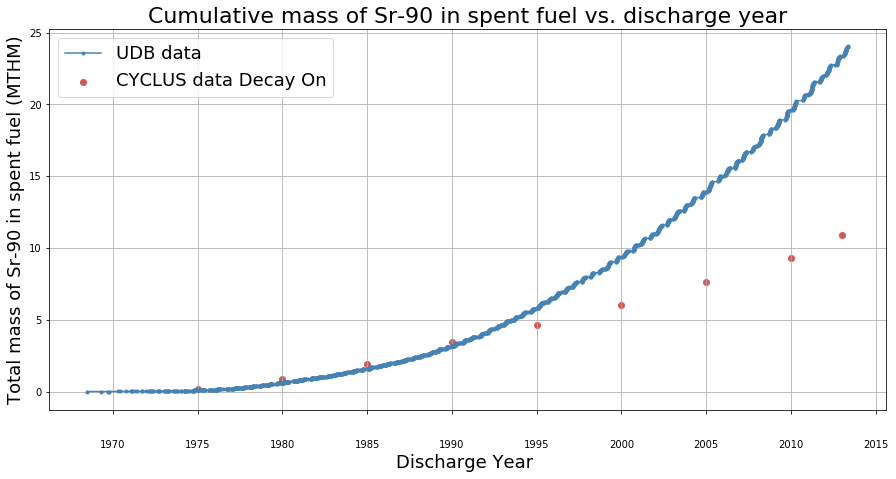

In [51]:
# Sr-90
CURIE_isotope_single_sr90 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'sr-90')] # isotope name 
CURIE_isotope_single_sr90 = CURIE_isotope_single_sr90.to_frame()
CURIE_isotope_single_sr90 = CURIE_isotope_single_sr90.multiply(0.000001)
index = CURIE_isotope_single_sr90.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_sr90.columns.values)
data = CURIE_isotope_single_sr90.values
data2 = underestm_Sr90_array_cum
data3 = overestm_Sr90_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Sr-90 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Sr-90 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Sr-90_cumulative_mass_spent_fuel_decayon.png', dpi=300)

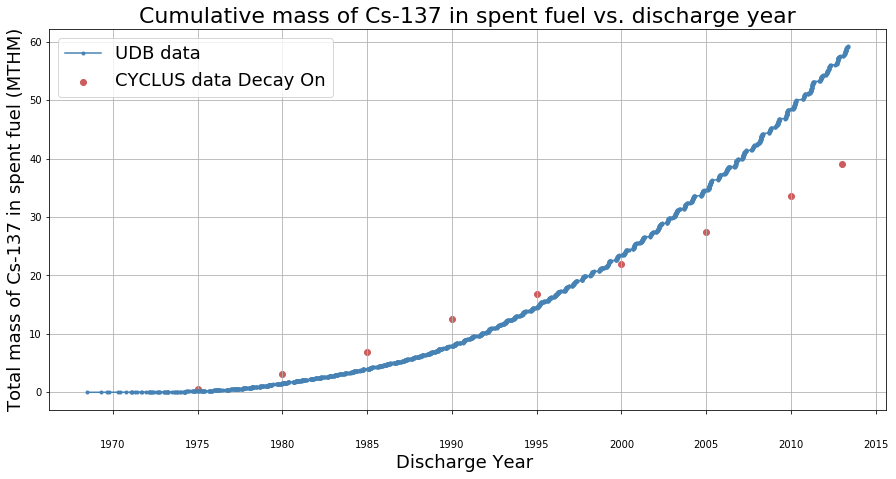

In [52]:
# Cs-137
CURIE_isotope_single_cs137 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'cs-137')] # isotope name 
CURIE_isotope_single_cs137 = CURIE_isotope_single_cs137.to_frame()
CURIE_isotope_single_cs137 = CURIE_isotope_single_cs137.multiply(0.000001)
index = CURIE_isotope_single_cs137.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_cs137.columns.values)
data = CURIE_isotope_single_cs137.values
data2 = underestm_Cs137_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Cs-137 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Cs-137 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Cs-137_cumulative_mass_spent_fuel_decayon.png', dpi=300)